In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

# Redes Convolutivas: Visão e Dados Tabulares

#### Instrutores:
    Welton Rodrigo e Witenberg Souza

###### Bem-vindos ao Tutorial de Construção de uma Rede Neuronal Convolutiva.

Este tutorial está divido em duas partes:

1- Contruir uma rede Convulitiva (CNN) e treiná-la em conjunto de imagens de vestuário.

2- Adquirir boas práticas no uso de matrizes de Embeddings.

---- PASSO-A-PASSO  ----

###### 0-  Importar Bibliotecas

######  Pré-requisitos para o tutorial de hoje:
1 - graphviz - costruir grafos visuais (Pré-requisito para o hiddenlayer)

2 - Hiddenlayer: Visualizar Nossa rede em forma de grafo

In [26]:
!sudo conda install graphviz python-graphviz -y 
#!sudo pip install hiddenlayer

In [2]:
# Apoio
import torch
from torch import randn
import torchvision.models as torch_models
import hiddenlayer as hl
import numpy as np

In [3]:
# Fastai
from fastai.vision import *
from fastai.metrics import error_rate
#from fastai.basics import *

###### 1 - Baixar o Fashion MNIST, um conjunto de imagens de vestuário.

In [ ]:
!wget https://github.com/zalandoresearch/fashion-mnist/archive/master.zip
!mv fashion-mnist-master.zip data/fashion-mnist-master.zip
!unzip master.zip
#!git clone https://github.com/zalandoresearch/fashion-mnist.git data/fashion_mnist

###### 1.1 Preparar nossso diretório com os dados.

In [ ]:
#!mkdir /data/fashion_minist

In [4]:
path ='data/fashion_mnist'

In [5]:
from data.fashion_mnist.utils import mnist_reader

######  1.2 Separar entre Treinamento e Teste

In [59]:
x_train, y_train = mnist_reader.load_mnist(f'{path}/data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist(f'{path}/data/fashion', kind='t10k')

In [60]:
x_train = np.reshape(x_train , (x_train.shape[0],1,x_train.shape[1])).astype('float32')
y_train = y_train.astype('int64')

x_test = np.reshape(x_test, (x_test.shape[0],1,x_test.shape[1])).astype('float32')
y_test = y_test.astype('int64')

In [62]:
x_train.shape,x_train.dtype

((60000, 1, 784), dtype('float32'))

###### 1.3 Visualizar Amostra

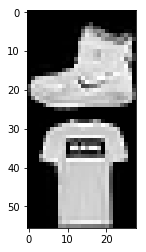

In [33]:
plt.imshow(x_train[0:2].reshape((56,28)), cmap="gray");


###### 1.4 Dividir entre Treinamento e Validação

In [63]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train[0:np.int(x_train.shape[0]*0.7)],
                                                     y_train[0:np.int(y_train.shape[0]*0.7)],
                                                     x_train[np.int(x_train.shape[0]*0.7):x_train.shape[0]-1],
                                                     y_train[np.int(y_train.shape[0]*0.7):y_train.shape[0]-1]))
n,t,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()


(torch.Size([42000, 1, 784]), tensor(0), tensor(9))

######  1.5  Prepara o Dataset para o Treinamento

In [64]:
bs=32
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [65]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([32, 1, 784]), torch.Size([32]))

###### 2 Contruir esta rede CNN:

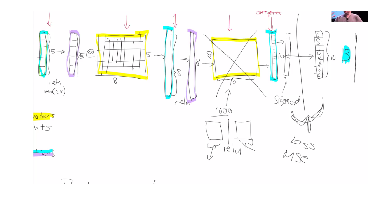

In [62]:
img = plt.imread(f'rede.png')
plt.axis('off')
plt.imshow(img)

######  2.0 -Definir:
1- Tamanho das imagens: sz

2- Batch size: bs

In [17]:
sz=28*28 #224
#bs = 64 #32

######  Funções Auxiliares

In [18]:
# Função para Tranformar Serializar MAtrizes MxN em vetores 1* N*M
#%%
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [66]:
y_train.shape, np.unique(y_train)

(torch.Size([42000]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64))

In [67]:
class_names = (len(np.unique(y_train)),)

In [68]:
class_names[0]

10

In [69]:
x_train.shape[2]

784

###### 2.1-Arquitetura da Rede

In [23]:
# Rede CNN Típica de camadas sequencias.
shape_ch =x_train.shape[2]
shape_mid = np.int(((shape_ch-2)/2)+1)
shape_fin =np.int(((shape_ch-4)/4)+1)
net = nn.Sequential()
net.add_module('Conv2_1',nn.Conv1d(in_channels=1, out_channels=shape_ch, kernel_size=3,bias=True))
net.add_module('BatchNorm_1',nn.BatchNorm1d(shape_ch))
net.add_module('reLU_1',nn.ReLU())
net.add_module('Conv2_2',nn.Conv1d(in_channels=shape_ch, out_channels=shape_mid, kernel_size=3,bias=True))
net.add_module('BatchNorm_2',nn.BatchNorm1d(shape_mid))
net.add_module('reLU_2',nn.ReLU())
net.add_module('Conv2_3',nn.Conv1d(in_channels=shape_mid, out_channels=shape_fin, kernel_size=3,bias=True))
net.add_module('BatchNorm_3',nn.BatchNorm1d(shape_fin))
net.add_module('flatten',Flatten())
net.add_module('linear_1', nn.Linear(shape_ch*shape_fin-(shape_ch+shape_mid ),class_names[0]))
net.add_module('classifier',nn.LogSoftmax())

net = net.cuda()

In [24]:
net

Sequential(
  (Conv2_1): Conv1d(1, 784, kernel_size=(3,), stride=(1,))
  (BatchNorm_1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (reLU_1): ReLU()
  (Conv2_2): Conv1d(784, 392, kernel_size=(3,), stride=(1,))
  (BatchNorm_2): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (reLU_2): ReLU()
  (Conv2_3): Conv1d(392, 196, kernel_size=(3,), stride=(1,))
  (BatchNorm_3): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten()
  (linear_1): Linear(in_features=152488, out_features=10, bias=True)
  (classifier): LogSoftmax()
)

###### 2.2 Contrução do Grafo Visual da Rede

###### 2.2.1  Opção para Sintetizar as conecções da rede

In [34]:
#%%
hl_transforms = [
        # Fold Conv, BN, RELU layers into one\n",
        hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu","ConvBnRelu"),
        # Fold Conv, BN, RELU layers into one\n",
        hl.transforms.Fold("ConvBnRelu > Conv > BatchNorm","CvBnRl_CvBn","CvBnRl_CvBn"),
        # Fold Conv, BN layers together",
        hl.transforms.Fold("Conv > BatchNorm", "ConvBn","ConvBn"),
        # Fold bottleneck blocks",
        hl.transforms.Fold("""(CvBnRl_CvBn | ConvBn)""","Bottleneck_Par"),
        hl.transforms.Fold("Bottleneck_Par  > Add > Relu", "Botl_Block","Bottleneck Block"),
        # Fold residual blocks",
        hl.transforms.Fold("""CvBnRl_CvBn > Add > Relu""",
                           "ResBlock","Residual Block"),                 
        # Fold repeated blocks",
        hl.transforms.FoldDuplicates(),
]

###### 2.2.2 Apresentar Rede

C:\Users\Witenberg\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\module.py:487: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self._slow_forward(*input, **kwargs)


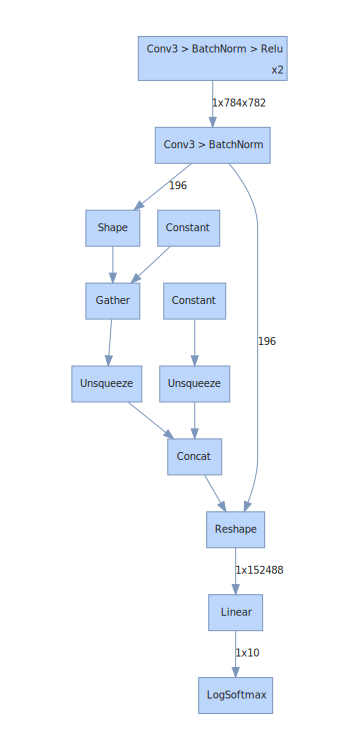

In [25]:
model_fakeData = randn(1,1,sz).cuda()
hl_graph = hl.build_graph(net,model_fakeData)
hl_graph.theme = hl.graph.THEMES["blue"]
hl_graph

###### 3 Treinar

In [123]:
data.show_batch

<bound method DataBunch.show_batch of DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x0000007B2DD24208>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x0000007B2DD24940>;

Test: None>

###### 3.0 Taxa Inicial

In [70]:
lr=2e-2

###### 3.1 Otimização

In [71]:
loss_func = nn.CrossEntropyLoss()

######  3.2 Leaner

In [72]:
learn1 = Learner(data, net, loss_func=loss_func, metrics=error_rate)

######  3,3 Iniciar Varredura de Melhor Taxa

C:\Users\Witenberg\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


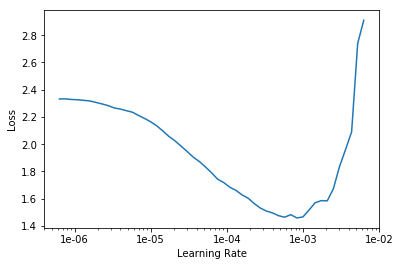

In [73]:
learn1.lr_find()
learn1.recorder.plot()

###### 3.4 Treinar com One Cycle

In [75]:
learn1.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.587768,0.530275,0.126396,15:54


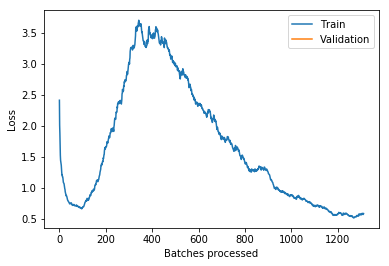

In [76]:
learn1.recorder.plot_losses()

In [77]:
learn1.save('fastaiv1_cnn_fashion')

###### 4 Apresentar Resultados

In [78]:
interp = ClassificationInterpretation.from_learner(learn1)

In [79]:
losses,idxs = interp.top_losses()

In [80]:
len(data.valid_ds)==len(losses)==len(idxs)

True

In [114]:
classes = np.unique(interp.y_true)

In [133]:
data.c,data.classes = len(np.unique(interp.y_true)),classes.astype('str')

###### 4.1 Matriz de Confusão

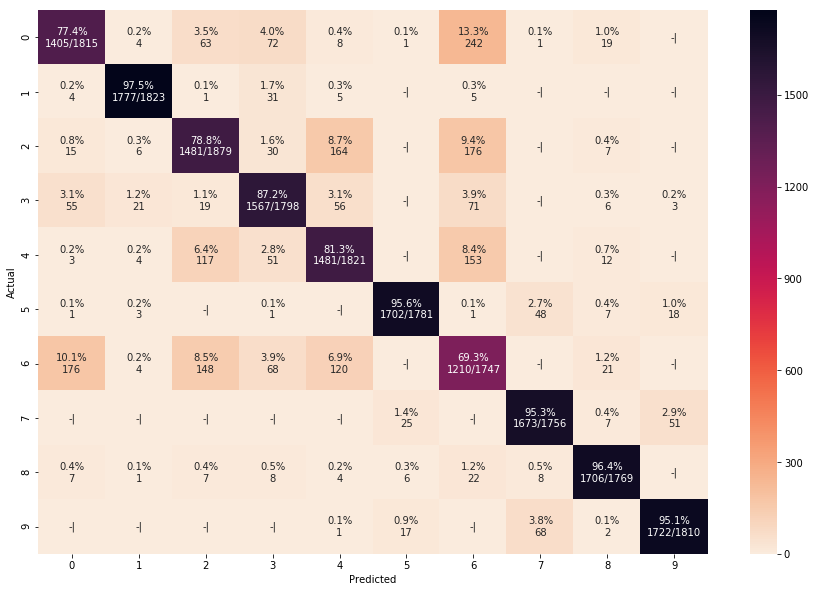

In [141]:
from plots_confusion_matrix import cm_analysis
cm_analysis(interp.y_true,interp.pred_class, 'confusion_fashion.png', labels=data.classes, ymap=None,figsize=(15,10))

In [126]:
interp.most_confused()

[('0', '6', 242),
 ('2', '6', 176),
 ('6', '0', 176),
 ('2', '4', 164),
 ('4', '6', 153),
 ('6', '2', 148),
 ('6', '4', 120),
 ('4', '2', 117),
 ('0', '3', 72),
 ('3', '6', 71),
 ('6', '3', 68),
 ('9', '7', 68),
 ('0', '2', 63),
 ('3', '4', 56),
 ('3', '0', 55),
 ('4', '3', 51),
 ('7', '9', 51),
 ('5', '7', 48),
 ('1', '3', 31),
 ('2', '3', 30),
 ('7', '5', 25),
 ('8', '6', 22),
 ('3', '1', 21),
 ('6', '8', 21),
 ('0', '8', 19),
 ('3', '2', 19),
 ('5', '9', 18),
 ('9', '5', 17),
 ('2', '0', 15),
 ('4', '8', 12),
 ('0', '4', 8),
 ('8', '3', 8),
 ('8', '7', 8),
 ('2', '8', 7),
 ('5', '8', 7),
 ('7', '8', 7),
 ('8', '0', 7),
 ('8', '2', 7),
 ('2', '1', 6),
 ('3', '8', 6),
 ('8', '5', 6),
 ('1', '4', 5),
 ('1', '6', 5),
 ('0', '1', 4),
 ('1', '0', 4),
 ('4', '1', 4),
 ('6', '1', 4),
 ('8', '4', 4),
 ('3', '9', 3),
 ('4', '0', 3),
 ('5', '1', 3),
 ('9', '8', 2),
 ('0', '5', 1),
 ('0', '7', 1),
 ('1', '2', 1),
 ('5', '0', 1),
 ('5', '3', 1),
 ('5', '6', 1),
 ('8', '1', 1),
 ('9', '4', 1)]

###### 4.2 Outras Métricas

In [142]:
from sklearn.metrics import classification_report
print(classification_report(interp.y_true,interp.pred_class,target_names=data.classes))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1815
           1       0.98      0.97      0.98      1823
           2       0.81      0.79      0.80      1879
           3       0.86      0.87      0.86      1798
           4       0.81      0.81      0.81      1821
           5       0.97      0.96      0.96      1781
           6       0.64      0.69      0.67      1747
           7       0.93      0.95      0.94      1756
           8       0.95      0.96      0.96      1769
           9       0.96      0.95      0.96      1810

   micro avg       0.87      0.87      0.87     17999
   macro avg       0.87      0.87      0.87     17999
weighted avg       0.88      0.87      0.87     17999



In [158]:
interp.y_true,interp.y_true

(tensor([9, 4, 3,  ..., 1, 3, 0]), tensor([9, 4, 3,  ..., 1, 3, 0]))

In [161]:
accuracia = np.mean(np.asarray(interp.pred_class)==np.asarray(interp.y_true),dtype=np.float32)

In [162]:
print("Acuracia= {:0.2f}".format(accuracia*100)+'%')

Acuracia= 87.36%


###### 2.3  Opção 2: Rede Residual

In [89]:
#Bloco Residual
class Residual(nn.Module):
    def __init__(self,args):
        super().__init__()
        in_ch = args[0][0]
        out_ch = args[0][1]
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3,bias=True)
        self.batchnorm1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=in_ch, kernel_size=1)
        
    def forward(self, input):
        saida1 = self.conv1(input)
        saida1_normalizada = self.batchnorm1(saida1)
        saida_relu = self.relu1(saida1_normalizada)
        saida2 = self.conv2(saida_relu) 
        saida = torch.cat([saida1,saida2],1)
        return saida

###### 2.3.1 Rede Residual (Mini-Resnet)

In [120]:
net2 = nn.Sequential()
net2.add_module('residual1',Residual([[3,15]]))
net2.add_module('flatten',Flatten())
net2.add_module('linear_1', nn.Linear(887112,class_names[0]))
net2.add_module('classifier',nn.LogSoftmax())

net2 = net2.cuda()

In [121]:
net2

Sequential(
  (residual1): Residual(
    (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv2): Conv2d(15, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (flatten): Flatten()
  (linear_1): Linear(in_features=887112, out_features=10, bias=True)
  (classifier): LogSoftmax()
)

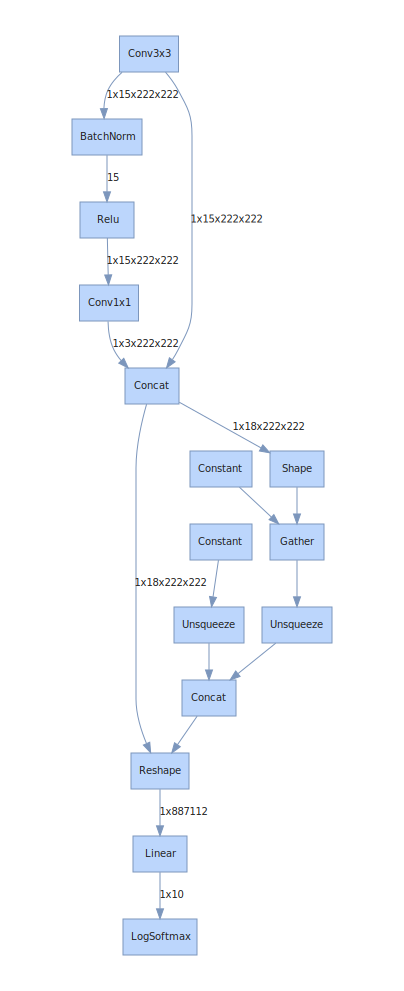

In [122]:
hl_graph = hl.build_graph(net2,model_fakeData)
hl_graph.theme = hl.graph.THEMES["blue"]
hl_graph

In [159]:
learn2 = Learner(data, net2, loss_func=loss_func, metrics=error_rate)

# Agora Vamos Explorar Embeddings!!